<a href="https://colab.research.google.com/github/PLPerkins/DeepLearningforMedicalImageAnalysisI/blob/master/microassignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

# Radiomics - 1p/19q Chromosome Status Classification Using Deep Learning

**Special thanks to:**  
- Dr. Bradley J. Erickson M.D., Ph.D. - Department of Radiology - Mayo Clinic
- Panagiotis Korfiatis, Ph.D. - Department of Radiology - Mayo Clinic
- Dr. Daniel LaChance, M.D. - Department of Neurology - Mayo Clinic

**Acknowledgment**
National Cancer Institute (NCI), *GrantNo. CA160045* and The Cancer Imaging Archive (TCIA)


## Introduction
Diagnosis of a brain tumor can be devastating to patients. Surgery is an essential step in management, and can be painful and life-threatening. Often the next step is radiation and chemotherapy which also has side effects and is expensive. Targeted therapies based on genetic properties of the tumor can improve response and reduce the side effects of treatment.  Thanks to work being performed at Mayo Clinic, new approaches using deep learning techniques to detect biomarkers can lead to more effective treatments and yield better health outcomes.


## Background

Radiogenomics refers to the correlation between cancer imaging features and gene expression. Radiogenomics can be used to create biomarkers that identify the genomics of a disease without the use of an invasive biopsy. A biomarker is simply an indicator of some biological state or condition. Four biomarkers that appear important for brain tumors include 1p/19q chromosome co-deletion; MGMT-promoter methylation; IDH-1 mutation; and TERT. The focus of this lab is detection of 1p/19q co-deletion using deep learning, using convolutional neural networks. What is remarkable about this research is the novelty and promising results of combining deep learning with Radiogenomics. In addition to avoiding invasive biopsies, the detection or absence of biomarkers is significant because certain treatments of brain tumors are more effective in the presence or absence of a biomarker. Biomarker detection can ensure patients receive the most effective treatment for their particular scenario.

Research performed shows that the detection of 1p/19q co-deletion using deep learning works well with T2 images compared to T1 post contrast images. Additionally, fewer layers and fewer neurons per layer produced better results while limiting overfitting of the training data. The model you will build consists of 19 layers.  Kernels (convolutions) were found to yield positive results when the convolutions were smaller - 3 x 3 - since these smaller convolutions could capture some of the finer details of the edges.  Originally the model was created using Keras and Theano framework, but we have altered the code slightly so that the TensorFlow framework could be used.  Tensorflow has great multi-GPU support - a necessity when working with large training datasets and complex neural networks - hence, the change in framework.

The lab instructions that follow will guide you through one approach to establishing your own convolutional neural network to detect 1p/19q co-deletion biomarker. You will likely experiment with alterations to the network architecture, hyper-parameters and training data. We encourage you to do such experimentation and to utilize deep learning for the detection of other biomarkers


## Getting Started
Before going into details on architecting and training a neural network, there are some housekeeping tasks that need to be executed first.  Examples of such tasks include: 
- Importing libraries
- Setting necessary parameters for reproducibility 

The above list reflects only some of the basic tasks you may need to perform at your site.

Go ahead and place your cursor in each of the three code boxes below and click the "run cell" button.

In [ ]:
# Load general use libraries 
import os
import sys
import time
import random
import string
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from _loadcsvdeep import load_set # custom function to load the data

In [ ]:
# Load keras libraries
print ('I am process:')
print (os.getpid())
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Activation, Dense, Dropout
from keras.utils import np_utils
from keras.callbacks import TensorBoard

import keras
import keras.backend as K
from keras.layers.core import ActivityRegularization
#from keras_diagram import ascii # fuction to print the network 
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping

I am process:
67


Using TensorFlow backend.


In [ ]:
# Load sklearn libraries for evaluation purposes
from sklearn.utils import shuffle
import itertools
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn import metrics as me
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import math
seed = 7 # For reproducibility
from sklearn.metrics import confusion_matrix
from collections import Counter

## Network Architecture 
The code block that follows defines our network architecture and provides code that visualizes the model's performance.  Notice how easy it is to define a 19-layer convolution neural network!  Let's take a closer look at some of the layers in the network architecture by exploring the Keras / TensorFlow options used.
<br>
<br>
<br>
**Sequential()**

Immediately after the def cnn_model line below we see the following code: 

*model = Sequential()*

Sequential() is a Keras specification that allows us to create a linear stack of layers in our neural network architecture.
<br>
<br>
<br>
**Conv2D()**

*model.add(Conv2D(16, (3, 3),activation='linear',kernel_initializer='he_uniform'))*

Kernels act like filters.  Each kernel slides over an input image / space to yield a value that projects to a new space (see picture below).  As noted earlier, smaller convolutions offered better results because the smaller convolutions capture some of the finer details of the edges of a tumor.  All convolutional layers in this network use 3 X 3 kernels.  The architecture starts with 16 kernels in a layer, moves to using 32 kernels per layer, then 64 kernels per layer, and reaches a high of 96 kernels per layer.


One of the major advantages of using deep neural networks is that you do not have to define the features yourself.  Convolutions find features in the data for you.  Each kernel needs an initial set of weights. There are numerous approaches to initializing these weights - 'he_uniform' was chosen here.  Feel free to experiment using other weight initialization options.
<br>
<br>
<img src="images/Convolution.png" width="400" height="300">
<br>
<br>
<br>
**LeakyReLU()**

*model.add(LeakyReLU(alpha=.01))*

LeakyReLU is one of many activation functions (sigmoid, tanh, ReLU, etc.) that can be selected.  Valuable information resides in the negative values when it comes to Radiogenomics.  As such, LeakyReLU was chosen as the activation function since negative values are retained and avoid saturation concerns sometimes experienced when using tanh.
<br>
<br>
<br>
**MaxPooling2D()**

*model.add(MaxPooling2D(pool_size=(2, 2)))*

Pooling is a down-sampling technique that reduces the number of computations that must be performed.  Maxpooling identifies the most important feature in a specified area (2 X 2 given the example above) and projects the maximum value onto a new space.  This model initially uses 2 X 2 maxpooling and then uses 7 X 7 maxpooling.
<br>
<br>
<br>
**Flatten()**

*model.add(Flatten())*

Flattens the input. Does not affect the batch size.
<br>
<br>
<br>
**Dense()**

*model.add(Dense(512))*

Dense reduces the number of neurons in a layer.  Dense is used twice to bring the number of neurons down to two just before the softmax layer to reflect what will be the binary prediction of either 'co-deletion' or 'no co-deletion'.
<br>
<br>
<br>
**GaussianNoise()**

*model.add(keras.layers.noise.GaussianNoise(0.3))*

To prevent overfitting of the training data, noise was intentionally added.
<br>
<br>
<br>
**Dropout()**

*model.add(Dropout(0.5))*

Dropout represents yet another means of preventing or limiting overfitting of your model to the training data.  Dropout randomly avoids neurons during the forward and backward propogation phases.  The number of neurons not updating depends upon the value specified inside Dropout().  In this example, half (0.5) of the neurons are skipped.
<br>
<br>
<br>
**Activation('softmax')**

*model.add(Activation('softmax'))*

The last layer in our network, the output layer, uses a softmax classifier to include the probability of each of the binary outcomes - 'co-deletion' and 'no co-deletion'.

**_Network Architecture Quiz_**

<a name="Network_Architecture_Questions"></a>

[Network Architecture Quiz Answers](#Network_Architecture_Answers)


If you do not know the answer, feel free to search the internet.

**Question 1:**  What are the advantages and disadvantages to having fewer layers?

A. Two features can be associated with fewer layers; fewer computations resulting in the training times for the model will take less time or certain features not being detected causing the model to be more accurate. 

**Question 2:**  What are the advantages and disadvantages to having fewer neurons?

A. With fewer neurons the computation time would be less resulting in faster training times. However, fewer neurons indicates there are fewer features. Fewer features could either result in accuracy levels being poor or less than expected; on the other hand, the accuracy levels could be acceptable. 

**Question 3:**  Why might you choose a smaller kernel size and why might you choose a larger kernel size?

A.  A smaller kernel size would be used to get lower number of weights and more layers. Essentially, the smaller kernels will capture finer details. This may cause issues as the an accurate level of representation for the model may not be achieved. On the other hand, larger kernel sizes would be used for generic attribute to capture basic image components. The layers would be less but the number of weights is higher. This would allow for shorter computation times.

**Question 4:**  Is MaxPooling the only type of pooling?

A. No, along with MaxPooling there is global max pooling, average pooling and global average pooling. 

**Question 5:**  What does overfitting mean?

A. Overfitting means the training data is modeled too well causing random fluctuations to be learned as concepts of the model. This causes issues as new features will not be detected well.

In [ ]:
def train_validate(Y_train,X_train,model1,output,lr_reducer,early_stopper,loss='binary_crossentropy',optimizer='Adam', metrics=['categorical_accuracy'],batch_size=32, nb_epoch=20, weighting=True):
    nb_epoch=int(nb_epoch)
    # Evaluate the model using three-fold cross validation
    # Stratified --> each fold contains roughly the same proportions of the two types of class labels.
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    
    i=0
    
    # Keep scores during validation in cross-validation phase
    cvscores_v = []
    rocval_v=[]
    prediction_v=[]
    recall_v=[]
    f1_v=[]
    weights=model1.get_weights()
    for train, test in kfold.split(X_train, Y_train):
        model=model1
        model.set_weights(weights)
        program_starts = time.time()

        i+=1
        
        #Will produce a csv file with all the training history
        csv_logger=CSVLogger(output+'/qp_logs'+str(i)+'.csv')
        
        model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)
        
        print ('Fold', str(i))
        print (10*'----------')
        print (10*'----------')
        
        # Estimate the weights for this fold
        class_weights = get_class_weights(Y_train[train])
        # Save the best model
        tbCallBack = keras.callbacks.TensorBoard(log_dir='/dli/tasks/tensorboard', histogram_freq=0, write_graph=True, write_images=True)
        best_model = ModelCheckpoint(output+'/1p19q'+str(i)+'.h5', verbose=0, monitor='val_loss',save_best_only=True)
        #Perform the fitting
        if weighting:
            history=model.fit(X_train[train], Y_train[train],
                  batch_size=batch_size,
                  epochs=nb_epoch,
                  validation_data=(X_train[test], Y_train[test]),
                  shuffle=True,
                  callbacks=[lr_reducer, csv_logger,early_stopper,best_model,tbCallBack],class_weight = class_weights,verbose=0)
        else:
            history=model.fit(X_train[train], Y_train[train],
                  batch_size=batch_size,
                  epochs=nb_epoch,
                  validation_data=(X_train[test], Y_train[test]),
                  shuffle=True,
                  callbacks=[lr_reducer, csv_logger,early_stopper,best_model,tbCallBack],verbose=0)            
        # Load the weights corresponding to the best model created during training process  
        model.load_weights(output+'/1p19q'+str(i)+'.h5')
        
        # Estimate accuracy on validation set
        print ('Overall accuracy: Validation')
        scores = model.evaluate(X_train[test],  Y_train[test], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores_v.append(scores[1] * 100)
        
        # Plot loss curves
        f = plt.figure()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()      
        f.savefig(output+"/1p19q_curves"+str(i)+".pdf")
        
        print ('Validation')
        Y_cv_pred = model.predict(X_train[test], batch_size = 32)
        Y_cv_pred[Y_cv_pred>0.5]=1
        Y_cv_pred[Y_cv_pred<1]=0
        score1 = accuracy_score( Y_train[test], Y_cv_pred)
        
        print('Confusion matrix: Validation')
        print(confusion_matrix( Y_train[test], Y_cv_pred))        
        print ("The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.The support is the number of samples of the true response that lie in that class.")
        target_names=['1p19q deleted', '1p19q not deleted' ]
        
        print(classification_report( Y_train[test], Y_cv_pred, target_names=target_names,digits=4))
        valid_preds = model.predict(X_train[test], verbose=0)
        prediction_v.append( (me.precision_score( Y_train[test], Y_cv_pred,average='weighted')))
        recall_v.append((me.recall_score( Y_train[test], Y_cv_pred,average='weighted')))
        f1_v.append(me.f1_score( Y_train[test], Y_cv_pred,average='weighted'))
        print (10*'----------')
        print (10*'----------')
        now = time.time()
        print("It took {0} seconds to complete fold training".format(now - program_starts))        
        # Delete the model and history before the next fold
        del model
    print('Summary')
    
    #Validation metrics
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_v), np.std(cvscores_v)))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(prediction_v), np.std(prediction_v)))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(recall_v), np.std(recall_v)))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(f1_v), np.std(f1_v)))
    
    
def cnn_model(img_rows, img_cols, img_channels, noise=0.4,dense_layer=1024, load_pretrain=True):
    model = Sequential()
    model.add(Conv2D(16, (3, 3),activation='linear',kernel_initializer='he_uniform',
                     input_shape=(img_rows, img_cols, img_channels)))
    model.add(LeakyReLU(alpha=.01))   # add an advanced activation
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2)) # Avoid over-fitting 
    model.add(Conv2D(32, (3, 3),activation='linear',kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=.01))   # add an advanced activation
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2)) # Avoid over-fitting 
    model.add(Conv2D(64, (3, 3),activation='linear',kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=.01))   # add an advanced activation
    model.add(MaxPooling2D(pool_size=(10, 10)))
    model.add(keras.layers.noise.GaussianNoise(noise))
    model.add(Flatten())
    model.add(Dense(dense_layer))
    model.add(LeakyReLU(alpha=.01))   # add an advanced activation
    model.add(Dropout(0.5)) # Avoid over-fitting  
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    if load_pretrain==True:
        # Load best weights 
        model.load_weights(os.path.join('/dli/data/radiomics', '1p19q_full.h5'))
    return model


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.gray,savepdf='output.pdf'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    f=plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
#   plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix (no normalization)')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, ('%.2f' %cm[i, j]),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
   
# This function will set up the weights for problems with unbalanced data. 
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}


## Hyperparameters
Through the course of this research multiple hyperparameter values were tested.  The code below represents the combination of hyperparameters and their corresponding values that provided the best results.  When experimenting with this architecture or adapting it to your own data you may want to alter the values shown here to see if you get better results.  Let's take a closer look at some of the hyperparameters and code shown in the next code block.
<br>
<br>
<br>

**Batch Size**

The batch size indicates the number of images that are processed during forward propagation to yield a loss value that is used in backpropagation.  Typically batch size is set to a power of two and is limited by the amount of memory available.  Also, though larger batch size may allow for faster training, weights update less frequently and may fail to provide the best results.
<br>
<br>
<br>
**Number of Epochs**

The number of epochs represents the number of times the entire training dataset is iterated over when training your model.  Validation, performed at the end of each epoch, identifies how well the model generalizes to new data.

## Training monitoring 
**ReduceLROnPlateau()**

*lr_reducer = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=np.sqrt(0.1), cooldown=0, patience=2, min_lr=0.5e-6)*

The learning rate represents how much we move in a certain direction in attempt to find the global minima.  Since initial weight values are somewhat arbitrary, starting with a higher learning rate typically works fine.  As we progress through the training phase, we typically find that we get closer and closer to either the global or local minima.  Since we do not want to overshoot the minima, a common practice is to anneal the learning rate.  In other words, as we progress through the training phase, we start to take smaller and smaller steps in a certain direction.  ReduceLROnPlateau() represents one example of how you can anneal the learning rate.  In the code example above, we will keep reducing the learning rate by the square root of 0.1 when there is no change in the loss value as long as the learning rate has not reached a reduction of 0.5e-6.
<br>
<br>
<br>
**EarlyStopping()**

*early_stopper = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=10)*

Early stopping mechanisms help prevent or limit overfitting models to training data.  Also, early stopping mechanisms prevent unnecessary computations when results remain static.  The model presented here will stop training if for a patience of 10 (epochs) there has not been a change of at least 0.001.
<br>
<br>
<br>
**CSVLogger**

*csv_logger = CSVLogger('qp_logs.csv')*

CSVLogger() will create a csv file capturing the training progress report. 
<br>
<br>
<br>

**_Hyperparameter Quiz_**

<a name="Hyperparameter_Questions"></a>

[Hyperparameter Quiz Answers](#Hyperparameter_Answers)


If you do not know the answer, feel free to search the internet.

**Question 1:**  Why would you want to increase the batch size?  Identify one possible concern associated with larger batch sizes.

A. Increased batch size increases the chance back-propagation from occurring and may lead prevent overfitting. A concern of a larger batch size is the potential lack of accuracy. This could be due to the weights not being updated as often.

**Question 2:**  What are two roles early stopping mechanisms play when it comes to building models?

A. Early stopping mechanisms can stop overfitting. If it cannot stop overfitting, early stop mechanisms have the potential to limit overfitting.  

**Question 3:**  Why would you want to increase the number of epochs?  Why would you decrease the number of epochs?

A. An increase in the number of epochs may increase the model's accuracy. However, one may want to decrease the number of epochs since increasing the number of epochs could play a role in overfitting occurring. 

The code below provides values for some of the hyperparameters and creates the datasets.  After going through this lab with the pre-defined values, feel free to come back to this code and alter the hyperparameter values to see if you can improve upon the accuracy of your model.

In [ ]:
# Location to save the output of these code
output = os.path.join('/dli/data/radiomics', '1p19qTCGA')
if not os.path.exists(output):
    os.makedirs(output)


# For network monitoring
# Will reduce the learning rate
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=2, patience=10, min_lr=1e-7)

# if used will stop the training when the network stops improving for 10 epochs (patience)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

# Will create a summary of the training progress in CSV format.
csv_logger = CSVLogger(output+'/qp_logs.csv')

# Fit paramters
batch_size = 32

# How many epochs to train
nb_epoch = 60

# Input image dimensions 
img_rows, img_cols = 256, 256
img_channels = 1 # Gray scale images

# Dataset locations 
#TrainingValidation = os.path.join('/dli/data/radiomics', 'DATA', '1p19q', 'interTCGA_part1256.npz')
TrainingValidation = os.path.join('/dli/data/radiomics', 'interTCGA_part1256.npz')
#Testing = os.path.join('/dli/data/radiomics', 'DATA', '1p19q', 'interTCGA_part2256.npz')
Testing = os.path.join('/dli/data/radiomics', 'interTCGA_part2256.npz')


## Data Preparation and Building A Model
The code that follows creates an instance of the previously defined network and will use the previously defined hyperparameters values to build a model.  Code has been injected into various parts of the training phase to provide insight into how the model is progressing.  Also, some data preparation steps are included at the beginning of the following code block - removing a third class, normalizing the data, setting up cross-validation, etc.  Please take a moment to read through the following code before executing as the code reveals several approaches that can be taken in your own research to better understand both the data and the model produced.

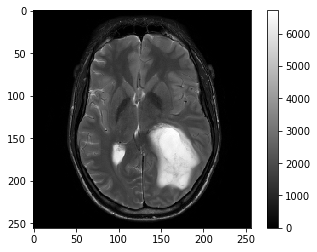

Training Validation Size
(1150, 1, 256, 256)
Testing size
(567, 1, 256, 256)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 16)      160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 254, 254, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 125, 125, 32)      0         
_________________________________________________________________

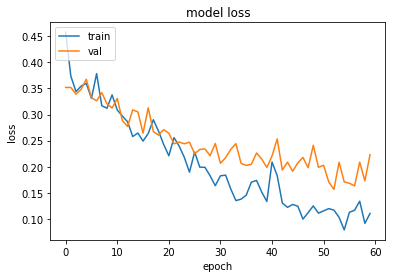

Validation
Confusion matrix: Validation
[[270   4]
 [ 13  97]]
The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.The support is the number of samples of the true response that lie in that class.
                   precision    recall  f1-score   support

    1p19q deleted     0.9541    0.9854    0.9695       274
1p19q not deleted     0.9604    0.8818    0.9194       110

      avg / total     0.9559    0.9557    0.9551       384

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
It took 190.543205976 seconds to complete fold training
('Fold', '2')
----------------------------------------------------------------------------------------------------
------

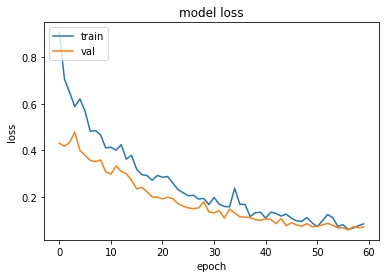

Validation
Confusion matrix: Validation
[[274   0]
 [  3 106]]
The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.The support is the number of samples of the true response that lie in that class.
                   precision    recall  f1-score   support

    1p19q deleted     0.9892    1.0000    0.9946       274
1p19q not deleted     1.0000    0.9725    0.9860       109

      avg / total     0.9923    0.9922    0.9921       383

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
It took 188.432442904 seconds to complete fold training
('Fold', '3')
----------------------------------------------------------------------------------------------------
------

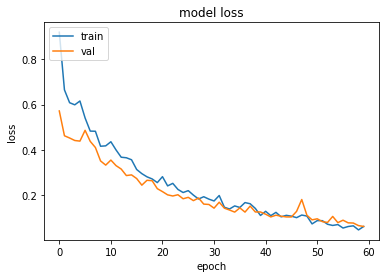

Validation
Confusion matrix: Validation
[[272   2]
 [  3 106]]
The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.The support is the number of samples of the true response that lie in that class.
                   precision    recall  f1-score   support

    1p19q deleted     0.9891    0.9927    0.9909       274
1p19q not deleted     0.9815    0.9725    0.9770       109

      avg / total     0.9869    0.9869    0.9869       383

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
It took 190.641042948 seconds to complete fold training
Summary
97.83% (+/- 1.61%)
0.98% (+/- 0.02%)
0.98% (+/- 0.02%)
0.98% (+/- 0.02%)


In [ ]:
# Load Training Validation        
X, y=load_set(path=TrainingValidation,scale=img_rows)

# Data contain a third class normal --> Remove it for this demo    
IND=np.nonzero(y==2)
Y_train = np.delete(y, IND)
Y_train=Y_train.astype(int)
X_train = np.delete(X, IND,axis=0)

# Delete temporary variables
del X, y

# Preview an image
plt.figure()
plt.imshow(np.rot90(X_train[400,0,:,:],3), cmap=plt.cm.gray)
plt.colorbar()
plt.show()

# Load Testing         
X, y=load_set(path=Testing,scale=img_rows)

# Data contain a third class normal --> Remove it for this demo    
IND=np.nonzero(y==2)
y_test = np.delete(y, IND)
y_test=y_test.astype(int)
X_test = np.delete(X, IND,axis=0)

# Shuffle the training data   
Y_train,X_train = shuffle(Y_train,X_train, random_state=0)
print ('Training Validation Size')
print (np.shape(X_train))
print ('Testing size')
print (np.shape(X_test))

# Normalize the data...the 10000 is set on the dataset creation process  
# All the data are T2 just used MRIcron to draw a line acrross Z direction of the tumor
X_train=X_train/10000
X_test=X_test/10000

X_train=X_train.reshape(-1,img_rows, img_cols, img_channels)
X_test=X_test.reshape(-1,img_rows, img_cols, img_channels)

model=cnn_model(img_rows, img_cols, img_channels, load_pretrain=True)
print(model.summary())
# Save the model in case that needs to be reused
model_json = model.to_json()
with open(os.path.join(output, 'FULL_MODEL.json'), 'w') as json_file:
    json_file.write(model_json)

adam=keras.optimizers.Adam(lr=0.0001)

train_validate(Y_train,X_train,model,output,lr_reducer,early_stopper,loss='binary_crossentropy',optimizer=adam, metrics=['binary_accuracy'],batch_size=32, nb_epoch=60, weighting=True)  


### Click [here](/tensorboard/) to start TensorBoard.

## Can you do better? 

Try to create your model and run cross validation 


 - Add/remove layers<br>
     For example:
     - model.add(Conv2D(8, (3, 3)))
     - model.add(Conv2D(16, (3, 3),activation='tanh',kernel_initializer='he_uniform')
     * Adjust maxpooling accordingly 
     [extra help](https://keras.io/layers/core/)
     
     
 - Try different optimizers <br>
     For example: Adam, SGD 
     - altoptimizer=keras.optimizers.SGD(lr=0.0001)
     - altoptimizer=keras.optimizers.Adam(lr=0.0001)
         - Change the learning rate:
you can choose values between .1 to 2e-6
     [extra help](https://keras.io/optimizers/)
            
     
 - Change convolution size <br>
     For example:
     - model.add(Conv2D(8, (5, 5)))


 - Try with and without using weights
     - choose weighting=True or weighting=Flase in **train_validate** function:
`train_validate(Y_train,X_train,mymodel,output,lr_reducer,early_stopper,loss='binary_crossentropy',optimizer=altoptimizer, metrics=['binary_accuracy'],batch_size=32, nb_epoch=nb_epoch,weighting=False)`



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 256, 256, 7)       14        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 256, 256, 7)       56        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 256, 256, 7)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 256, 256, 7)       56        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 256, 256, 7)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 256, 256, 7)       56        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 256, 256, 7)       0         
__________

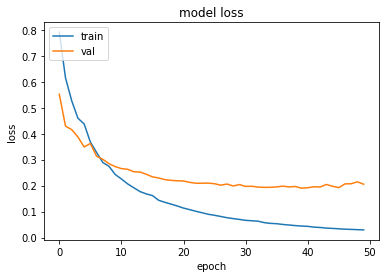

Validation
Confusion matrix: Validation
[[268   6]
 [ 12  98]]
The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.The support is the number of samples of the true response that lie in that class.
                   precision    recall  f1-score   support

    1p19q deleted     0.9571    0.9781    0.9675       274
1p19q not deleted     0.9423    0.8909    0.9159       110

      avg / total     0.9529    0.9531    0.9527       384

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
It took 179.641377926 seconds to complete fold training
('Fold', '2')
----------------------------------------------------------------------------------------------------
------

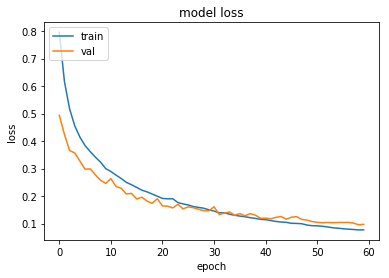

Validation
Confusion matrix: Validation
[[268   6]
 [  6 103]]
The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.The support is the number of samples of the true response that lie in that class.
                   precision    recall  f1-score   support

    1p19q deleted     0.9781    0.9781    0.9781       274
1p19q not deleted     0.9450    0.9450    0.9450       109

      avg / total     0.9687    0.9687    0.9687       383

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
It took 212.679106951 seconds to complete fold training
('Fold', '3')
----------------------------------------------------------------------------------------------------
------

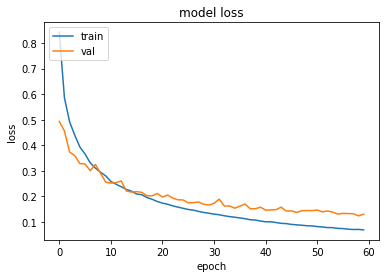

Validation
Confusion matrix: Validation
[[262  12]
 [  2 107]]
The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.The support is the number of samples of the true response that lie in that class.
                   precision    recall  f1-score   support

    1p19q deleted     0.9924    0.9562    0.9740       274
1p19q not deleted     0.8992    0.9817    0.9386       109

      avg / total     0.9659    0.9634    0.9639       383

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
It took 209.351960897 seconds to complete fold training
Summary
96.17% (+/- 0.65%)
0.96% (+/- 0.01%)
0.96% (+/- 0.01%)
0.96% (+/- 0.01%)


In [ ]:
def my_model(img_rows, img_cols, img_channels,dense_layer=32, load_pretrain=True):
    model = Sequential()
    model.add(Conv2D(7, (1, 1),
                     input_shape=(img_rows, img_cols, img_channels)))
    model.add(Conv2D(7, (1, 1)))
    model.add(MaxPooling2D(pool_size=(1,1)))
    model.add(Conv2D(7, (1, 1)))
    model.add(MaxPooling2D(pool_size=(1,1)))
    model.add(Conv2D(7, (1, 1)))
    model.add(MaxPooling2D(pool_size=(1,1)))
    model.add(Flatten())
    model.add(Dense(dense_layer))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

mymodel=my_model(img_rows, img_cols, img_channels)
print (mymodel.summary())
learningrate=0.00001
altoptimizer=keras.optimizers.Adam(lr=learningrate)
# or
#altoptimizer=keras.optimizers.SGD(lr=0.005)
nb_epoch=60

# Perform train and validation
train_validate(Y_train,X_train,mymodel,output,lr_reducer,early_stopper,loss='binary_crossentropy',optimizer=altoptimizer, metrics=['binary_accuracy'],batch_size=32, nb_epoch=nb_epoch,weighting=True)  



## Final Model Build Before Deployment (Testing)
Once you believe you have captured the best model, then it is time to evaluate a final set of results using all the data to ensure that the model's precision, recall and accuracy are at their optimum on the test set.  

It is important to note that the performance during the validation and testing phase must not differ significantly.


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Weights
{0: 1.0, 1: 2.0}


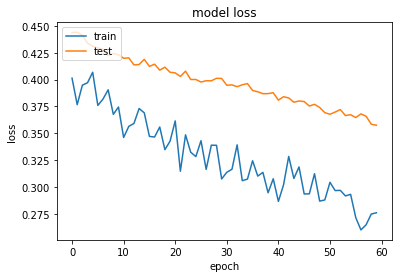

Testing Score
-------------
-------------
Area under the ROC
0.7918238993710692


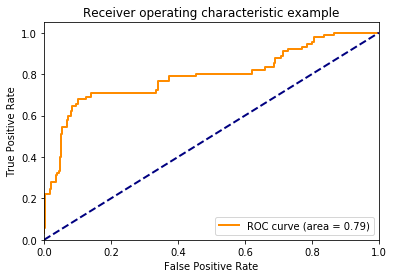

Overall Accuracy
0.855379188712522
The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.  The support is the number of samples of the true response that lie in that class.
                   precision    recall  f1-score   support

    1p19q deleted     0.9360    0.8889    0.9118       477
1p19q not deleted     0.5351    0.6778    0.5980        90

      avg / total     0.8723    0.8554    0.8620       567

precision_score
0.8723482731848016
recall_score
0.855379188712522
f1_score
0.8620202202744895
Confusion matrix: Test set
[[424  53]
 [ 29  61]]
Normalized confusion matrix
[[0.89 0.11]
 [0.32 0.68]]


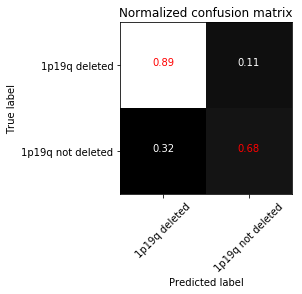

In [ ]:
# Create the final data utilizing all the data
nb_epochs=60
adam=keras.optimizers.Adam(lr=learningrate)
model=cnn_model(img_rows, img_cols, img_channels, load_pretrain=True)

# If you want to use the model you created uncommend the following two lines:
# adam=keras.optimizers.Adam(lr=0.00001)
# model=my_model(img_rows, img_cols, img_channels)


model.compile(loss='binary_crossentropy',
      optimizer=adam,
      metrics=['accuracy'])
print (10*'----------')
print (10*'----------')
# Estimate the weights
class_weight = get_class_weights(Y_train)
print('Weights')
print (class_weight)
# Save the best model
best_model = ModelCheckpoint(output+'/1p19q_fullc.h5', verbose=0, monitor='val_loss',save_best_only=True)
# Perform the fitting
tbCallBack = keras.callbacks.TensorBoard(log_dir='/dli/tasks/tensorboard', histogram_freq=0, write_graph=True, write_images=True)

history=model.fit(X_train, Y_train,
      batch_size=batch_size,
      epochs=nb_epochs,
      validation_split=.3,
      class_weight = class_weight,
      shuffle=True,
      callbacks=[lr_reducer, csv_logger,early_stopper,best_model,tbCallBack],verbose=0)

# Plot loss curves
f = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()      
f.savefig(output+"/1p19q_FULL.pdf")

# Perform analysis on the test set
print ('Testing Score')
print ('-------------')
print ('-------------')
Y_cv_pred = model.predict(X_test, batch_size = 32)
# Binarize output. ROC analysis can be used to come up with a better threshold 
fpr, tpr, _ = roc_curve(y_test, Y_cv_pred)
roc_auc= auc(fpr, tpr)
print ('Area under the ROC')
print (roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Y_cv_pred[Y_cv_pred>0.5]=1
Y_cv_pred[Y_cv_pred<1]=0
print ('Overall Accuracy')
score1 = accuracy_score(y_test, Y_cv_pred)
print(score1)
target_names=['1p19q deleted', '1p19q not deleted' ]


print ("The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.  The support is the number of samples of the true response that lie in that class.")
print(classification_report(y_test, Y_cv_pred, target_names=target_names,digits=4))
print ("precision_score")
print ( (me.precision_score(y_test, Y_cv_pred,average='weighted')))
print("recall_score")
print ((me.recall_score(y_test, Y_cv_pred,average='weighted')))
print ("f1_score")
print (me.f1_score(y_test, Y_cv_pred,average='weighted'))

print('Confusion matrix: Test set')
print(confusion_matrix( y_test, Y_cv_pred))
np.set_printoptions(precision=2)
cmatr=confusion_matrix( y_test, Y_cv_pred)
np.set_printoptions(precision=2)

# Plot the normalized confusion matrix and save the output
plot_confusion_matrix(cmatr, classes=target_names, normalize=True,
              title='Normalized confusion matrix',savepdf=output+"/1p19qconfusionmatrixfull.pdf")

## What Next
Many ways to explore and possibly improve model:

- Add additional layers to the network

- Change the number of neurons in those layers

- Change some of the hyperparameters in the network configuration like dropout or learning rate, etc.


Time permitting, go back to the code above and experiment with some of these suggested changes to see if you can achieve better results.

## Network Architecture Quiz Answers

<a name="Network_Architecture_Answers"></a>

[Network Architecture Quiz Questions](#Network_Architecture_Questions)

**Question 1:**  What are the advantages and disadvantages to having fewer layers?
<br>
<br>
**_Answer:_**  Fewer layers have fewer computations that must be performed which leads to faster training times.  However, it may also prevent the discovery of higher and higher level features that leads to more accurate models if more layers were included in the network architecture.
<br>
<br>
**Question 2:**  What are the advantages and disadvantages to having fewer neurons?
<br>
<br>
**_Answer:_**  Fewer neurons means that you have fewer features.  Fewer features may yield models with lower than expected accuracy levels.  Alternatively, if a smaller number of features yields acceptable levels of accuracy, then the reduced number of computations should yield faster training times.
<br>
<br>
**Question 3:**  Why might you choose a smaller kernel size and why might you choose a larger kernel size?
<br>
<br>
**_Answer:_**  Smaller kernel sizes may be better at capturing some of the finer details of an image that would otherwise be lost if larger kernel sizes were selected.  This could lead to a model that does not reach an acceptable level of accuracy.  Alternatively, larger kernel sizes reduce the number of computations being performed; thus, leading to shorter training times.  If a higher degree of information loss can be afforded, using larger kernel sizes may be desirable given the reduction in training time.  
<br>
<br>
**Question 4:**  Is MaxPooling the only type of pooling?
<br>
<br>
**_Answer:_**  There are other types of pooling such as Average Pooling, but MaxPooling is the most commonly used type of pooling.
<br>
<br>
**Question 5:**  What does overfitting mean?
<br>
<br>
**_Answer:_**  Overfitting occurs when the features identified during the training process are so specific to the training data that the resulting model does not generalize well to new data where the features may vary.

## Hyperparameter Quiz Answers

<a name="Hyperparameter_Answers"></a>

[Hyperparameter Quiz Questions](#Hyperparameter_Questions)


**Question 1:**  Why would you want to increase the batch size?  Identify one possible concern associated with larger batch sizes.
<br>
<br>
**_Answer:_**  Larger batch sizes result in faster training because backpropagation does not take place as often.  Researchers typically set batch size to the maximum number of images that can be held in memory without generating an "Out of Memory" error message.  Also, it is common to have the batch size set to a value that is a power of 2, but this is not a requirement.  The possible drawback to a larger batch size is that the weights are not updated as frequently which may result in a model that is not as accurate.  However, it may also mean that model is less likely to be overfitted to the training data.
<br>
<br>
**Question 2:**  What are two roles early stopping mechanisms play when it comes to building models?
<br>
<br>
**_Answer:_**  Early stopping mechanisms, where training ceases prematurely, can help limit or prevent overfitting the model to the training data and can also help conserve GPU resources.
<br>
<br>
**Question 3:**  Why would you want to increase the number of epochs?  Why would you decrease the number of epochs?
<br>
<br>
**_Answer:_**  Increasing the number of epochs may improve the accuracy of the model.  However, it may also lead to overfitting the model to the training data.  Experimentation with this hyperparameter along with the use of early stopping mechanisms are typical approaches to getting to an acceptable epoch value. Reviewing the loss curves during validation phase curve can help as well.  


<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>